# Laboratory Work 4  
## Application of Pretrained Model  
Oxford 102 Flowers Dataset

In [1]:
# Import Required Libraries

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

In [2]:
# Global Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(42)

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

batch_size = 32

Using device: cuda


## Task 1 — Dataset Selection and Preparation

The Oxford 102 Flowers dataset is loaded and preprocessed.  
Images are resized to 224×224 and normalized using ImageNet statistics.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
]) #transforms code

In [4]:
train_dataset_full = datasets.Flowers102(
    root="./data",
    split="train",
    download=True,
    transform=transform
)

val_dataset = datasets.Flowers102(
    root="./data",
    split="val",
    download=True,
    transform=transform
)

full_dataset = ConcatDataset([train_dataset_full, val_dataset]) #dataset loading

100%|██████████| 345M/345M [00:13<00:00, 25.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.05MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 30.5MB/s]


In [5]:
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size]
) #70/20 split

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #data loader

In [7]:
print("Total images:", len(full_dataset))
print("Training images:", len(train_dataset))
print("Testing images:", len(test_dataset))
print("Number of classes:", 102)

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)  #print info

Total images: 2040
Training images: 1428
Testing images: 612
Number of classes: 102
Batch shape: torch.Size([32, 3, 224, 224])


## Task 2 — Pretrained Model Loading

A pretrained ResNet18 model is loaded and analyzed.

In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)

print(model)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Task 3 — Transfer Learning with Frozen Backbone

All convolutional layers are frozen and only the final classification layer is trained.

In [9]:
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 102)
model = model.to(device) #freeze + replace fc

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_frozen = optim.Adam(model.fc.parameters(), lr=0.001) #loss and optimizer

In [11]:
# Training Loop — Frozen Backbone (8 Epochs)

num_epochs = 8

frozen_train_losses = []
frozen_test_losses = []
frozen_train_acc = []
frozen_test_acc = []

for epoch in range(num_epochs):

    # ----- Training Phase -----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_frozen.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_frozen.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    frozen_train_losses.append(train_loss)
    frozen_train_acc.append(train_acc)

    # ----- Evaluation Phase -----
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    frozen_test_losses.append(test_loss)
    frozen_test_acc.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}")
    print("--------------------------------------------------")

Epoch [1/8]
Train Loss: 4.3809 | Train Acc: 0.0945
Test  Loss: 3.5362 | Test  Acc: 0.3170
--------------------------------------------------
Epoch [2/8]
Train Loss: 2.7912 | Train Acc: 0.5630
Test  Loss: 2.5560 | Test  Acc: 0.5637
--------------------------------------------------
Epoch [3/8]
Train Loss: 1.8345 | Train Acc: 0.7731
Test  Loss: 1.9340 | Test  Acc: 0.6961
--------------------------------------------------
Epoch [4/8]
Train Loss: 1.2580 | Train Acc: 0.8908
Test  Loss: 1.5253 | Test  Acc: 0.7778
--------------------------------------------------
Epoch [5/8]
Train Loss: 0.8940 | Train Acc: 0.9251
Test  Loss: 1.3087 | Test  Acc: 0.7892
--------------------------------------------------
Epoch [6/8]
Train Loss: 0.6899 | Train Acc: 0.9475
Test  Loss: 1.1377 | Test  Acc: 0.8252
--------------------------------------------------
Epoch [7/8]
Train Loss: 0.5417 | Train Acc: 0.9657
Test  Loss: 1.0496 | Test  Acc: 0.8219
--------------------------------------------------
Epoch [8/8]
T

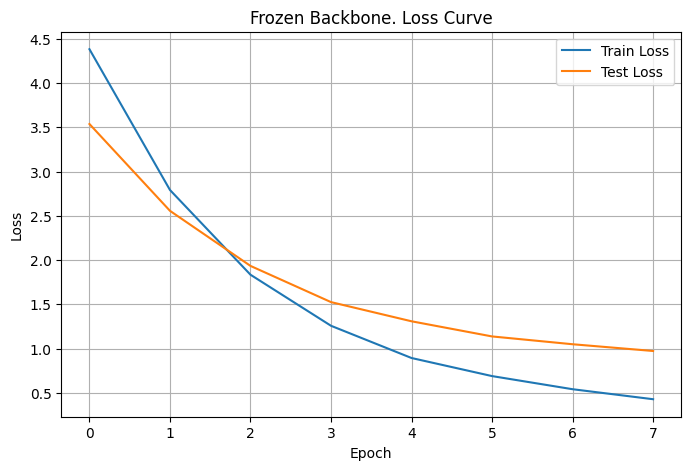

In [12]:
# Plot Loss Curves

plt.figure(figsize=(8,5))
plt.plot(frozen_train_losses)
plt.plot(frozen_test_losses)
plt.title("Frozen Backbone. Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.grid(True)
plt.show()

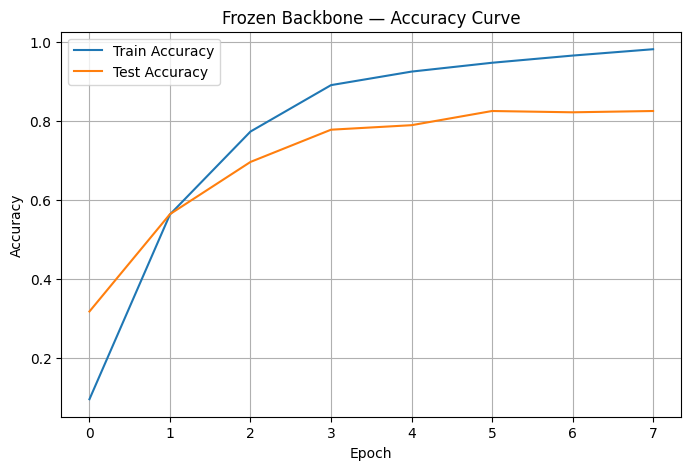

In [13]:
# Plot Accuracy Curves

plt.figure(figsize=(8,5))
plt.plot(frozen_train_acc)
plt.plot(frozen_test_acc)
plt.title("Frozen Backbone — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.grid(True)
plt.show()

In [14]:
torch.save(model.state_dict(), "resnet18_frozen.pth")

In [15]:
print("Final Test Accuracy (Frozen Backbone):", frozen_test_acc[-1])

Final Test Accuracy (Frozen Backbone): 0.8251633986928104


## Task 4 — Fine-Tuning Strategy

In this experiment, the last convolutional block (layer4) of ResNet18 is unfrozen,
while earlier layers remain frozen. The model is trained for 5 epochs using
Adam optimizer with learning rate 0.0001.

In [16]:
finetune_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
finetune_model = finetune_model.to(device) #load fresh pretrained model

In [17]:
# Freeze all layers first
for param in finetune_model.parameters():
    param.requires_grad = False

In [18]:
# Unfreeze last convolutional block
for param in finetune_model.layer4.parameters():
    param.requires_grad = True

In [19]:
# Replace classification head
num_features = finetune_model.fc.in_features
finetune_model.fc = nn.Linear(num_features, 102)

finetune_model = finetune_model.to(device)

In [20]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer_finetune = optim.Adam(
    filter(lambda p: p.requires_grad, finetune_model.parameters()),
    lr=0.0001
)

In [21]:
# Training Loop — Fine-Tuning (5 Epochs)

num_epochs = 5

finetune_train_losses = []
finetune_test_losses = []
finetune_train_acc = []
finetune_test_acc = []

for epoch in range(num_epochs):

    #traininf phase
    finetune_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_finetune.zero_grad()
        outputs = finetune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_finetune.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    finetune_train_losses.append(train_loss)
    finetune_train_acc.append(train_accuracy)

    #evaluation phase
    finetune_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = finetune_model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total

    finetune_test_losses.append(test_loss)
    finetune_test_acc.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_accuracy:.4f}")

Epoch [1/5]
Train Loss: 4.0066 | Train Acc: 0.2115
Test  Loss: 3.0675 | Test  Acc: 0.4657
Epoch [2/5]
Train Loss: 2.1110 | Train Acc: 0.8599
Test  Loss: 2.1702 | Test  Acc: 0.7451
Epoch [3/5]
Train Loss: 1.1539 | Train Acc: 0.9685
Test  Loss: 1.6372 | Test  Acc: 0.8366
Epoch [4/5]
Train Loss: 0.6210 | Train Acc: 0.9972
Test  Loss: 1.3165 | Test  Acc: 0.8791
Epoch [5/5]
Train Loss: 0.3361 | Train Acc: 1.0000
Test  Loss: 1.1331 | Test  Acc: 0.8954


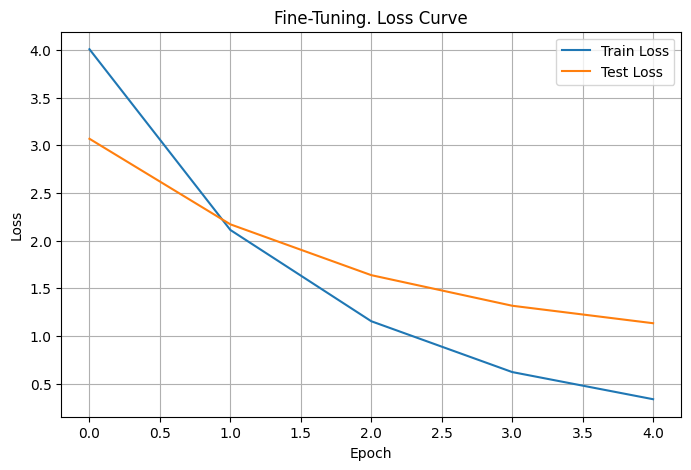

In [22]:
#plot loss
plt.figure(figsize=(8,5))
plt.plot(finetune_train_losses)
plt.plot(finetune_test_losses)
plt.title("Fine-Tuning. Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.grid(True)
plt.show()

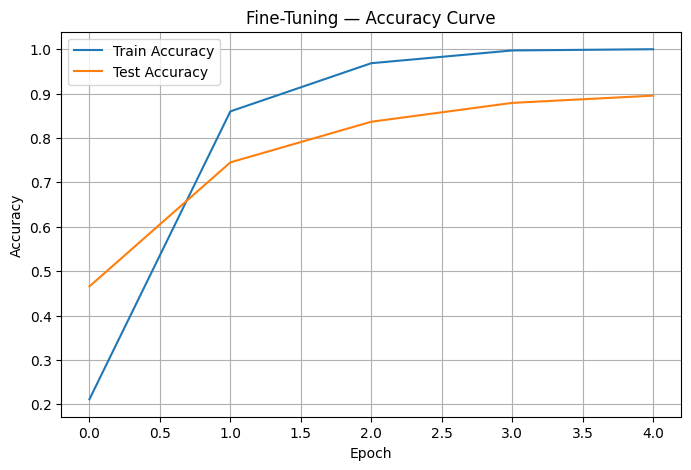

In [23]:
#plot accuracy
plt.figure(figsize=(8,5))
plt.plot(finetune_train_acc)
plt.plot(finetune_test_acc)
plt.title("Fine-Tuning — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.grid(True)
plt.show()

In [24]:
print("Final Test Accuracy (Fine-Tuning):", finetune_test_acc[-1])

Final Test Accuracy (Fine-Tuning): 0.8954248366013072


In [25]:
torch.save(finetune_model.state_dict(), "resnet18_finetuned.pth")

## Task 5 — Metrics-Based Evaluation

Both transfer learning strategies are evaluated using accuracy, precision,
recall and macro-averaged F1 score on the test set.

In [26]:
# Evaluation Function

def evaluate_model(model, dataloader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return acc, precision, recall, f1

In [27]:
# Load Frozen Model

frozen_model = models.resnet18(weights=None)
frozen_model.fc = nn.Linear(frozen_model.fc.in_features, 102)
frozen_model.load_state_dict(torch.load("resnet18_frozen.pth"))
frozen_model = frozen_model.to(device)

In [28]:
# Load Fine-Tuned Model

finetuned_model = models.resnet18(weights=None)
finetuned_model.fc = nn.Linear(finetuned_model.fc.in_features, 102)
finetuned_model.load_state_dict(torch.load("resnet18_finetuned.pth"))
finetuned_model = finetuned_model.to(device)

In [29]:
# Compute Metrics

frozen_metrics = evaluate_model(frozen_model, test_loader)
finetuned_metrics = evaluate_model(finetuned_model, test_loader)

In [30]:
# Comparison Table

results = pd.DataFrame({
    "Model": ["Frozen Backbone", "Fine-Tuning"],
    "Accuracy": [frozen_metrics[0], finetuned_metrics[0]],
    "Precision (Macro)": [frozen_metrics[1], finetuned_metrics[1]],
    "Recall (Macro)": [frozen_metrics[2], finetuned_metrics[2]],
    "F1 Score (Macro)": [frozen_metrics[3], finetuned_metrics[3]]
})

results

,Model,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
0,Frozen Backbone,0.825163,0.845366,0.837269,0.820672
1,Fine-Tuning,0.895425,0.903968,0.905641,0.893959


## Task 6 — Error Analysis

The better performing model (Fine-Tuned ResNet18) is analyzed using
a confusion matrix and visual inspection of correctly and incorrectly
classified test images.

In [31]:
# Collect Predictions for Confusion Matrix

model = finetuned_model
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

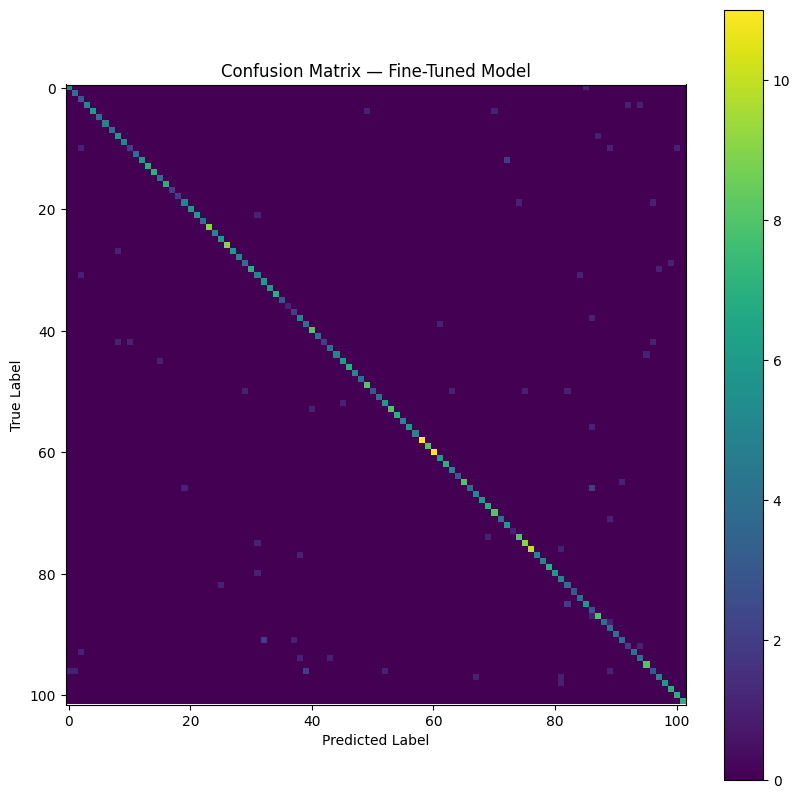

In [32]:
# Compute Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Fine-Tuned Model")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [33]:
# Denormalization Function
def denormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * imagenet_std + imagenet_mean
    img = np.clip(img, 0, 1)
    return img

In [34]:
# Collect 3 Correct and 3 Misclassified Images

correct_samples = []
incorrect_samples = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(images)):

            if preds[i] == labels[i] and len(correct_samples) < 3:
                correct_samples.append(
                    (images[i].cpu(), labels[i].cpu(), preds[i].cpu())
                )

            if preds[i] != labels[i] and len(incorrect_samples) < 3:
                incorrect_samples.append(
                    (images[i].cpu(), labels[i].cpu(), preds[i].cpu())
                )

            if len(correct_samples) == 3 and len(incorrect_samples) == 3:
                break

        if len(correct_samples) == 3 and len(incorrect_samples) == 3:
            break

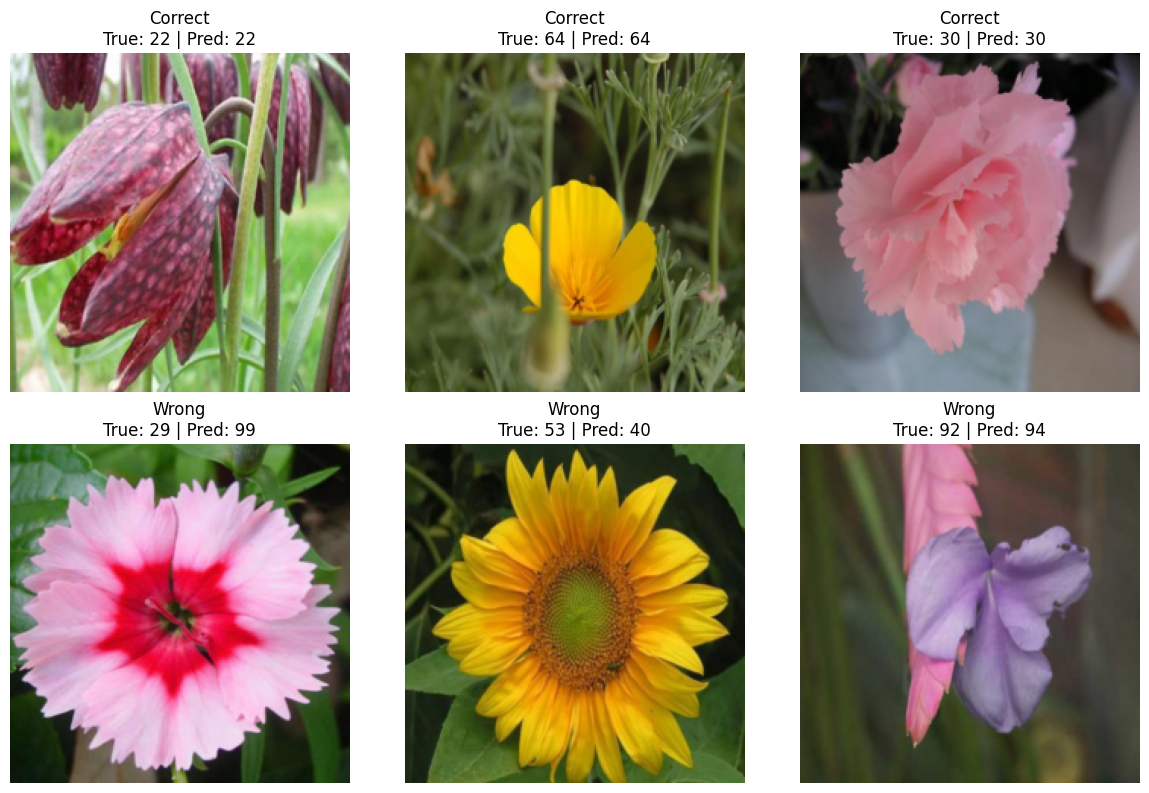

In [35]:
# Display Correct and Misclassified Images

plt.figure(figsize=(12, 8))

# Correct (Top Row)
for i, (img, true, pred) in enumerate(correct_samples):
    plt.subplot(2, 3, i+1)
    plt.imshow(denormalize(img))
    plt.title(f"Correct\nTrue: {true.item()} | Pred: {pred.item()}")
    plt.axis("off")

# Incorrect (Bottom Row)
for i, (img, true, pred) in enumerate(incorrect_samples):
    plt.subplot(2, 3, i+4)
    plt.imshow(denormalize(img))
    plt.title(f"Wrong\nTrue: {true.item()} | Pred: {pred.item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Task 7 — Training from Scratch

A small convolutional neural network is implemented and trained
from scratch using the same dataset split and optimizer settings
as in Task 3.

In [36]:
# Define Small CNN Model (Fewer Parameters)

class SmallCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SmallCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [37]:
# Initialize scratch model
scratch_model = SmallCNN().to(device)

In [38]:
scratch_params = sum(p.numel() for p in scratch_model.parameters())
print("Scratch Model Parameters:", scratch_params)

Scratch Model Parameters: 152486


In [39]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(scratch_model.parameters(), lr=0.001)

In [40]:
# Training Loop — Scratch Model (8 Epochs)

num_epochs = 8

scratch_train_losses = []
scratch_test_losses = []
scratch_train_acc = []
scratch_test_acc = []

for epoch in range(num_epochs):

    #training phase
    scratch_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_scratch.zero_grad()
        outputs = scratch_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_scratch.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    scratch_train_losses.append(train_loss)
    scratch_train_acc.append(train_accuracy)

    #evaluation phase
    scratch_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = scratch_model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total

    scratch_test_losses.append(test_loss)
    scratch_test_acc.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_accuracy:.4f}")

Epoch [1/8]
Train Loss: 4.6036 | Train Acc: 0.0140
Test  Loss: 4.4624 | Test  Acc: 0.0229
Epoch [2/8]
Train Loss: 4.1593 | Train Acc: 0.0357
Test  Loss: 3.9231 | Test  Acc: 0.0572
Epoch [3/8]
Train Loss: 3.7456 | Train Acc: 0.0868
Test  Loss: 3.6271 | Test  Acc: 0.0801
Epoch [4/8]
Train Loss: 3.5142 | Train Acc: 0.1120
Test  Loss: 3.5175 | Test  Acc: 0.1095
Epoch [5/8]
Train Loss: 3.3409 | Train Acc: 0.1422
Test  Loss: 3.3938 | Test  Acc: 0.1389
Epoch [6/8]
Train Loss: 3.2223 | Train Acc: 0.1751
Test  Loss: 3.3765 | Test  Acc: 0.1438
Epoch [7/8]
Train Loss: 3.0819 | Train Acc: 0.2066
Test  Loss: 3.3592 | Test  Acc: 0.1716
Epoch [8/8]
Train Loss: 2.9463 | Train Acc: 0.2136
Test  Loss: 3.3719 | Test  Acc: 0.1650


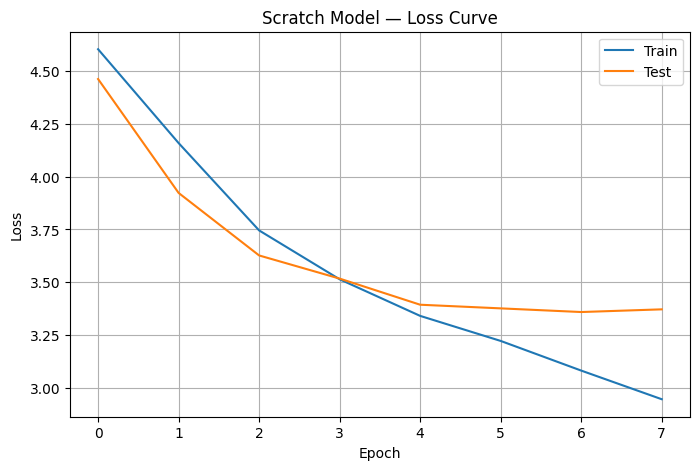

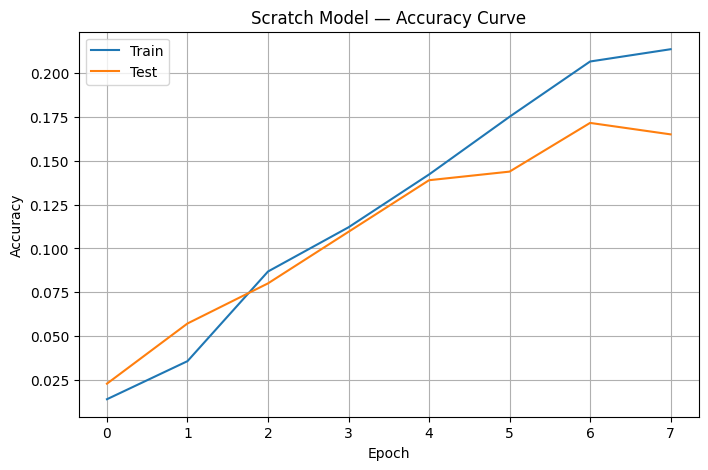

In [41]:
plt.figure(figsize=(8,5))
plt.plot(scratch_train_losses)
plt.plot(scratch_test_losses)
plt.title("Scratch Model — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(scratch_train_acc)
plt.plot(scratch_test_acc)
plt.title("Scratch Model — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])
plt.grid(True)
plt.show()

In [42]:
scratch_metrics = evaluate_model(scratch_model, test_loader)

## Task 8 — Feature Representation Analysis

Feature maps are extracted from one early convolutional layer and one deeper
convolutional layer of the fine-tuned ResNet18 model to analyze hierarchical
feature representation.

In [43]:
#select 1 test image
images, labels = next(iter(test_loader))

sample_image = images[0].unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]

In [44]:
# Register Forward Hooks

feature_maps = {}

def hook_fn(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

# Register hooks
early_hook = finetuned_model.conv1.register_forward_hook(hook_fn("early"))
deep_hook = finetuned_model.layer4.register_forward_hook(hook_fn("deep"))

In [45]:
# Forward pass
_ = finetuned_model(sample_image)

In [46]:
early_hook.remove()
deep_hook.remove() #deleting hooks

In [47]:
def denormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * imagenet_std + imagenet_mean
    img = np.clip(img, 0, 1)
    return img

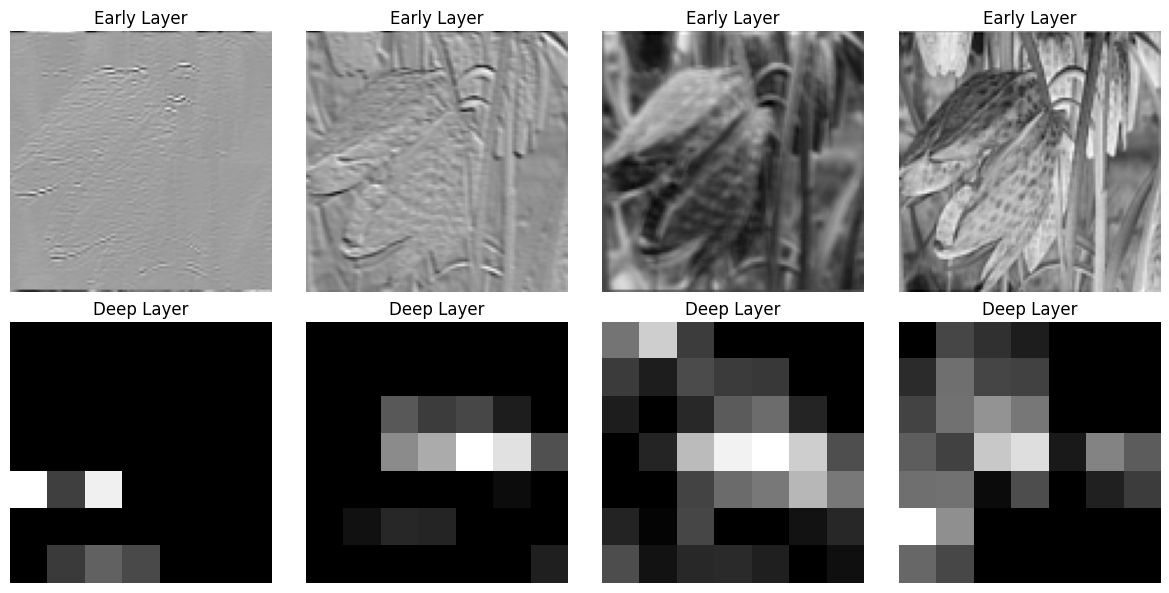

In [48]:
# Visualize Feature Maps

early_features = feature_maps["early"].cpu()
deep_features = feature_maps["deep"].cpu()

plt.figure(figsize=(12, 6))

# Early layer feature maps
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(early_features[0, i], cmap='gray')
    plt.title("Early Layer")
    plt.axis("off")

# Deep layer feature maps
for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.imshow(deep_features[0, i], cmap='gray')
    plt.title("Deep Layer")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Task 9 — Model Efficiency Analysis

The pretrained model and the model trained from scratch are compared
in terms of trainable parameters, training time per epoch, and final
test accuracy.

In [49]:
# Count Trainable Parameters

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

resnet_trainable = count_trainable_params(finetuned_model)
scratch_trainable = count_trainable_params(scratch_model)

print("Fine-Tuned ResNet18 Trainable Parameters:", resnet_trainable)
print("Scratch Model Trainable Parameters:", scratch_trainable)

Fine-Tuned ResNet18 Trainable Parameters: 11228838
Scratch Model Trainable Parameters: 152486


In [50]:
# Measure Training Time per Epoch

def measure_epoch_time(model, dataloader, optimizer, criterion):
    model.train()
    start_time = time.time()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    end_time = time.time()
    return end_time - start_time

In [51]:
resnet_time = measure_epoch_time(
    finetune_model,
    train_loader,
    optimizer_finetune,
    criterion
)

scratch_time = measure_epoch_time(
    scratch_model,
    train_loader,
    optimizer_scratch,
    criterion
)

In [52]:
resnet_accuracy = finetuned_metrics[0]
scratch_accuracy = scratch_metrics[0]

In [53]:
#Efficiency Comparison Table

efficiency_table = pd.DataFrame({
    "Model": ["Fine-Tuned ResNet18", "Scratch CNN"],
    "Trainable Parameters": [resnet_trainable, scratch_trainable],
    "Time per Epoch (sec)": [resnet_time, scratch_time],
    "Final Test Accuracy": [resnet_accuracy, scratch_accuracy]
})

efficiency_table

,Model,Trainable Parameters,Time per Epoch (sec),Final Test Accuracy
0,Fine-Tuned ResNet18,11228838,8.028261,0.895425
1,Scratch CNN,152486,7.991490,0.165033


The pretrained model contains significantly more parameters and requires slightly more computation time per epoch. However, it achieves substantially higher accuracy. This demonstrates the trade-off between model complexity and performance. Transfer learning allows leveraging pretrained representations to improve accuracy even with limited training data.